# Defining Prediction Tasks for Biomedical Text Mining

In [1]:
import json
import pandas as pd

# location for the datasets
data_dir = "./baseline/data"

## Loading PubMed Toxicogenomics Dataset

In [2]:
# PubMed training dataset from PubTator
with open(data_dir + "/train.json") as f:
    train_json = json.loads(f.read())

# validation split of 1521 examples (2%)
with open(data_dir + "/valid.json") as f:
    valid_json = json.loads(f.read())

# manually curated by biologists (1939)
with open(data_dir + "/test.json") as f:
    test_json = json.loads(f.read())

In [3]:
for doc in valid_json:
    title_length = len(doc['title'])
    for entity in doc['entity']:
        entity['label'] = entity.pop('type')

for doc in test_json:
    title_length = len(doc['title'])
    for entity in doc['entity']:
        entity['label'] = entity.pop('type')

In [4]:
# toxicogenomics interactions that are annotated in the dataset 
relation_map = json.loads(open(data_dir + "/relation_map.json").read())

## Biomedical Text Mining

In [5]:
import re

# 
abstracts = [doc['title']+" "+doc['abstract'] for doc in test_json]

pubmed = pd.DataFrame({'text': abstracts})

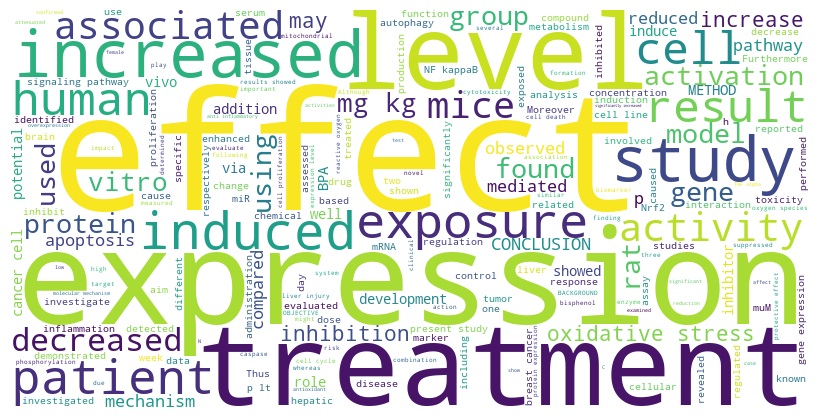

In [6]:
# Importing necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(abstracts)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
                     
plt.figure(figsize=(8, 4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In biomedical text we find common terms like "effect", "expression", and "treatment" as well as specialized jargon and abbreviations

In [7]:
import nltk
import string

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramonreszat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ramonreszat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

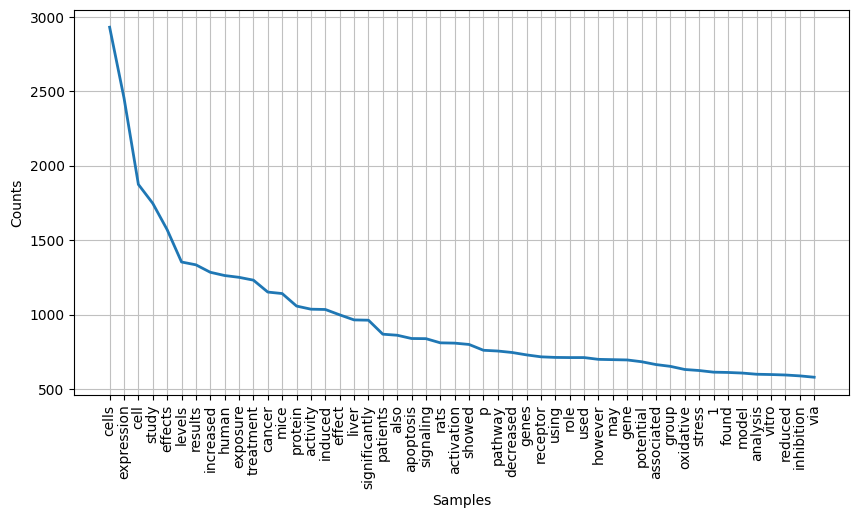

In [8]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

tokens = word_tokenize(text.lower())
stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token not in stop_words]
tokens = [token for token in tokens if token not in string.punctuation]
freq_dist = FreqDist(tokens)

plt.figure(figsize=(10, 5))
freq_dist.plot(50, cumulative=False)

plt.show()

In [9]:
TTR = len(set(tokens)) / len(tokens)
print("Lexical diversity in technical writing: {:.1f}%".format(TTR*100))

Lexical diversity in technical writing: 9.9%


In [10]:
freq_dis = freq_dist.items()

## Entity Recognition

In [11]:
from spacy import displacy

doc = test_json[500]

doc_dict = {
    "title": doc['title'],
    "text": doc['title']+" "+doc['abstract'],
    "ents": doc['entity']
    }

entity_colors = {
    "Chemical": "#E9DF85", "Disease": "#ff6961", "Gene": "#85C1E9"
    }

displacy.render(doc_dict, manual=True, style="ent",
                 options={"colors": entity_colors})

## Relation Extraction

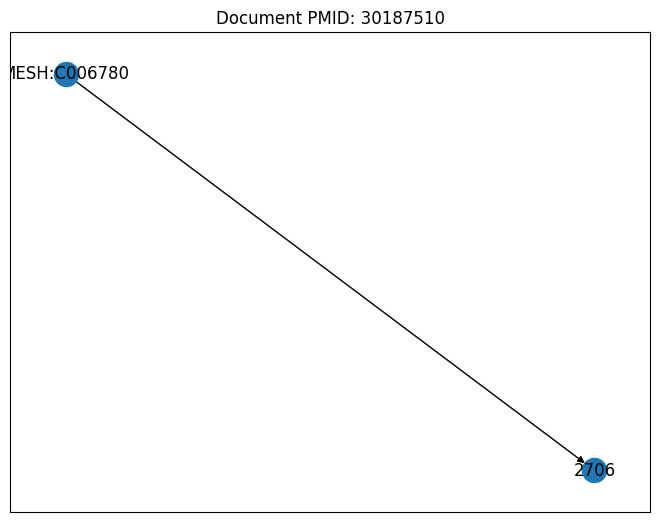

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

source, target, relations = [], [], []

for rel in doc['relation']:
    source.append(rel['subj'])
    target.append(rel['obj'])
    relations.append(rel['type'])
    
graph_df = pd.DataFrame({'source_id':source, 
        'target_id':target, 'edge_id':relations})

G=nx.from_pandas_edgelist(graph_df, "source_id", "target_id", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

pos = nx.spring_layout(G, seed=42)

nx.draw(G, with_labels=True, pos=pos)
plt.title('Document PMID: '+doc['docid'])
plt.axis('on')

plt.show()

In [9]:
doc['relation']

[{'type': 'chem_gene:decreases^expression',
  'subj': 'MESH:C006780',
  'obj': '2706'}]

## Manual Curation

Construct a network representation from the corpus of 523 abstracts, with entity mentions from PubTator Central that were *manually curated* by a team of biologists.

In [15]:
# collect information for network analysis
docids, source, target, relations = [], [], [], []
e1_names, e2_names, e1_type, e2_type = [], [], [], []

for doc in test_json:
    for rel in doc['relation']:
        docids.append(doc['docid'])
        source.append(rel['subj'])
        # 
        result = [item for item in doc['entity'] if item['id'] == rel['subj']]
        e1_names.append(result[0]['mention'])
        e1_type.append(result[0]['label'])

        target.append(rel['obj'])

        result = [item for item in doc['entity'] if item['id'] == rel['obj']]
        e2_names.append(result[0]['mention'])
        e2_type.append(result[0]['label'])

        relations.append(rel['type'])
    

# constructing a knowledge graph 
kg_df = pd.DataFrame({'document': docids, 'source_id':source, 'source_name': e1_names, 'source_type': e1_type,
                        'target_id':target, 'target_name': e2_names, 'target_type': e2_type,
                         'edge_id':relations})

In [16]:
kg_df

,document,source_id,source_name,source_type,target_id,target_name,target_type,edge_id
0,29883990,MESH:C103505,AM251,Chemical,1268,CB1,Gene,chem_gene:decreases^activity
1,29883990,MESH:C103505,AM251,Chemical,4313,matrix metalloproteinase (MMP) 2,Gene,chem_gene:increases^expression
2,29902480,3569,IL-6,Gene,MESH:D001249,asthma,Disease,gene_disease:marker/mechanism
3,29953732,MESH:D013311,streptozotocin,Chemical,MESH:D005355,fibrosis,Disease,chem_disease:marker/mechanism
4,30020114,MESH:D001564,benzo(a)pyrene,Chemical,595,cyclinD1,Gene,chem_gene:increases^expression
...,...,...,...,...,...,...,...,...
5111,33146391,MESH:D010126,Ozone,Chemical,2321,FMS-like tyrosine kinase-1,Gene,chem_gene:increases^transport
5112,33146391,MESH:D010126,Ozone,Chemical,4319,mmp10,Gene,chem_gene:decreases^expression
5113,33149750,MESH:D008070,Lipopolysaccharide,Chemical,5742,cyclooxygenase-1,Gene,chem_gene:increases^expression
5114,33259630,MESH:D002104,Cd,Chemical,MESH:D009765,obesity,Disease,chem_disease:marker/mechanism


In [10]:
kg_df.to_csv(data_dir + "/test_kg.txt", sep='\t', index=False)

In [11]:
# What can i do with this graph?
# 1. Analyze clusters in the gene-disease network
# 2. Align parts of the network with Wikipathways